# Cycle Gan Implementation

In [1]:
# import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import scipy.io
import struct
import tensorflow as tf

In [2]:
# some helper functions (taken from the sample solution to HW8 and changed to fit our needs)
# We will define functions for the layers so our code is not redundant.

# we can't always use same-padding, because sometimes no additional padding is necessary 
# (if reflection padding has already been applied)
def conv_layer(x, kernels_n, kernel_size, stride_size, activation_fn, normalize, pad="SAME"):
    initializer = tf.random_normal_initializer(stddev=0.02)
    
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, x.shape[-1], kernels_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [kernels_n], tf.float32, tf.zeros_initializer())
    
    drive = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = pad) + biases
    
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    if activation_fn == 'linear':
        return drive
    else:
        return activation_fn(drive)

# we can't always use same-padding, because sometimes no additional padding is necessary 
# (if reflection padding has already been applied)
def back_conv_layer(x, target_shape, kernel_size, stride_size, activation_fn, normalize, pad="SAME"):
    initializer = tf.random_normal_initializer(stddev=0.02)
    
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, target_shape[-1], x.shape[-1]], tf.float32, initializer)
    biases = tf.get_variable("biases", [target_shape[-1]], tf.float32, tf.zeros_initializer())
    drive = tf.nn.conv2d_transpose(x, kernels, target_shape, strides = [1, stride_size, stride_size, 1], padding = pad) + biases
    
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    return activation_fn(drive)


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])

def batch_norm(x, axes):
    mean, var = tf.nn.moments(x, axes = axes)
    
    offset_initializer = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [x.shape[-1]], tf.float32, offset_initializer)
    scale_initializer = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [x.shape[-1]], tf.float32, scale_initializer)
    
    return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

def residual_block(x, scope):
    # consists of two weight layers
    # skip-connection after the second layer
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        #apply reflection padding
        res_block = tf.pad(x, [[0,0,], [1,1,], [1,1,], [0,0,]], "REFLECT")
        res_block = conv_layer(res_block, 256, 3, 1, tf.nn.relu, True, pad="VALID")
        res_block = tf.pad(res_block, [[0,0,], [1,1,], [1,1,], [0,0,]], "REFLECT")
        # no activation function; activation fuction is applied to the sum of the input and the calculated residue
        res_block = conv_layer(res_block, 256, 3, 1, "linear", True, pad="VALID")
        #skip connection
        return tf.nn.relu(x + res_block)
    

In [3]:
# read MNIST data (only training data, as we don't have enough computational power for a test cycle)
# our domain X
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
mnist_images = read_idx('./MNIST/train-images-idx3-ubyte')
mnist_labels = read_idx('./MNIST/train-labels-idx1-ubyte')

# Normalize the training data.
mnist_images = np.expand_dims(mnist_images, 3)
normalized_mnist_images = (mnist_images / 255) * 2 - 1
#normalized_mnist_images = normalized_mnist_images[0:1000, :, :, :]

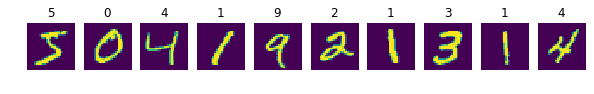

In [4]:
# show some mnist images with labels
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    ax[i].imshow(mnist_images[i,:,:,0])
    ax[i].axis('off')
    ax[i].set_title(mnist_labels[i])

In [5]:
# read SVHN data (only training data, as we don't have enough computational power for a test cycle)
# our domain Y

def load_svhn(path):
    
    matfile = scipy.io.loadmat(path)
    images = matfile['X']
    images = np.expand_dims(images,0)
    images = np.swapaxes(images, 0,4)
    svhn_images = np.squeeze(images)
    labels = matfile['y']
    svhn_labels = np.squeeze(labels)
    
    return svhn_images, svhn_labels


svhn_images, svhn_labels = load_svhn('./SVHN/train_32x32.mat')

normalized_svhn_images = (svhn_images / 255) * 2 - 1
#normalized_svhn_images = normalized_svhn_images[0:1000, :, :, :]

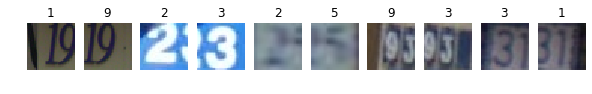

In [6]:
# show some svhn images with labels
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    ax[i].imshow(svhn_images[i,:,:,0:3])
    ax[i].axis('off')
    ax[i].set_title(svhn_labels[i])

In [7]:
# Define the hyperparameters of the model.

batch_size = 1

image_buffer_size = 50





In [8]:
tf.reset_default_graph()

#mnist_labels = mnist_labels[0:1000]
#svhn_labels = svhn_labels[0:1000]


# Create the datasets.
mnist_dataset = tf.data.Dataset.from_tensor_slices((normalized_mnist_images, mnist_labels))
svhn_dataset = tf.data.Dataset.from_tensor_slices((normalized_svhn_images, svhn_labels))


# Shuffle the training data in each iteration.
mnist_dataset = mnist_dataset.shuffle(buffer_size = 60000)
#mnist_dataset = mnist_dataset.shuffle(buffer_size = 1000)
svhn_dataset = svhn_dataset.shuffle(buffer_size = 73257)
#svhn_dataset = svhn_dataset.shuffle(buffer_size = 1000)

# Specify the batch sizes.
mnist_dataset = mnist_dataset.batch(batch_size, drop_remainder=True)
svhn_dataset = svhn_dataset.batch(batch_size, drop_remainder=True)

In [9]:
# Create the iterators.
mnist_iterator = tf.data.Iterator.from_structure(mnist_dataset.output_types,
                                           mnist_dataset.output_shapes)
svhn_iterator = tf.data.Iterator.from_structure(svhn_dataset.output_types,
                                           svhn_dataset.output_shapes)

# Name the operations that will give the next batch and name the 
# initialization operations.
next_batch_mnist = mnist_iterator.get_next()
next_batch_svhn = svhn_iterator.get_next()

training_init_op_mnist = mnist_iterator.make_initializer(mnist_dataset)
training_init_op_svhn = svhn_iterator.make_initializer(svhn_dataset)

# Architecture

# Generators 

From the paper: 
Let c7s1-k denote a 7 × 7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1. 
dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2. 
Reflection padding was used to reduce artifacts. 
Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters 
on both layers. uk denotes a 3 × 3 fractional-strided-Convolution-InstanceNorm-ReLU layer with k filters 
and stride 1 .
The network with 6 residual blocks consists of:
c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

In [10]:
# generator G: X->Y
# generates svhn images from mnist images

mnist_real = tf.cast(next_batch_mnist[0], dtype=tf.float32)

# generator network
def G(mnist_real):
    # 7 × 7 Convolution-InstanceNorm-ReLU layer
    with tf.variable_scope("G_first_layer", reuse=tf.AUTO_REUSE):
        #apply reflection padding
        # padding of 5 instead of 3 to compensate for different sizes of svhn and mnist images
        padded_mnist_input = tf.pad(mnist_real, [[0,0,], [5,5,], [5,5,], [0,0,]], "REFLECT")
        gen_G_layer_1 = conv_layer(padded_mnist_input, 64, 7, 1, tf.nn.relu, True, pad="VALID")

    # two 3 × 3 Convolution-InstanceNorm-ReLU layers
    with tf.variable_scope("G_downsampling_layer_1", reuse=tf.AUTO_REUSE):
        gen_G_layer_2 = conv_layer(gen_G_layer_1, 128, 3, 2, tf.nn.relu, True)
    with tf.variable_scope("G_downsampling_layer_2", reuse=tf.AUTO_REUSE):
        gen_G_layer_3 = conv_layer(gen_G_layer_2, 256, 3, 2, tf.nn.relu, True)
    
    # 6 residual blocks
    with tf.variable_scope("G_residual_block_1", reuse=tf.AUTO_REUSE):
        gen_G_layer_4 = residual_block(gen_G_layer_3, "G_residual_block_1")
    with tf.variable_scope("G_residual_block_2", reuse=tf.AUTO_REUSE):
        gen_G_layer_5 = residual_block(gen_G_layer_4, "G_residual_block_2")
    with tf.variable_scope("G_residual_block_3", reuse=tf.AUTO_REUSE):
        gen_G_layer_6 = residual_block(gen_G_layer_5, "G_residual_block_3")
    with tf.variable_scope("G_residual_block_4", reuse=tf.AUTO_REUSE):
        gen_G_layer_7 = residual_block(gen_G_layer_6, "G_residual_block_4")
    with tf.variable_scope("G_residual_block_5", reuse=tf.AUTO_REUSE):
        gen_G_layer_8 = residual_block(gen_G_layer_7, "G_residual_block_5")
    with tf.variable_scope("G_residual_block_6", reuse=tf.AUTO_REUSE):
        gen_G_layer_9 = residual_block(gen_G_layer_8, "G_residual_block_6")

    # two 3 × 3 fractional-strided-Convolution-InstanceNorm-ReLU layer
    # (fractionally strided convolution = backward convolution)
    with tf.variable_scope("G_upsampling_layer_1", reuse=tf.AUTO_REUSE):
        gen_G_layer_10 = back_conv_layer(gen_G_layer_9, [batch_size, 16, 16, 128], 3, 2, tf.nn.relu, True)
    with tf.variable_scope("G_upsampling_layer_2", reuse=tf.AUTO_REUSE):
        gen_G_layer_11 = back_conv_layer(gen_G_layer_10, [batch_size, 32, 32, 64], 3, 2, tf.nn.relu, True)

    # 7 × 7 Convolution-InstanceNorm-ReLU layer
    with tf.variable_scope("G_last_layer", reuse=tf.AUTO_REUSE):
        #apply reflection padding
        svhn_output = tf.pad(gen_G_layer_11, [[0,0,], [3,3,], [3,3,], [0,0,]], "REFLECT")
        # 3 filters, because we want rgb output (3 channels)
        svhn_output = conv_layer(svhn_output, 3, 7, 1, tf.nn.tanh, True, pad="VALID")
    
    return svhn_output

svhn_generated = G(mnist_real)

In [11]:
# generator F: Y->X
# generates mnist images from svhn images

svhn_real = tf.cast(next_batch_svhn[0], dtype=tf.float32)


# generator network
def F(svhn_real):
    # 7 × 7 Convolution-InstanceNorm-ReLU layer
    with tf.variable_scope("F_first_layer", reuse=tf.AUTO_REUSE):
        #apply reflection padding
        padded_svhn_input = tf.pad(svhn_real, [[0,0,], [3,3,], [3,3,], [0,0,]], "REFLECT")
        gen_F_layer_1 = conv_layer(padded_svhn_input, 64, 7, 1, tf.nn.relu, True, pad="VALID")

    # two 3 × 3 Convolution-InstanceNorm-ReLU layers
    with tf.variable_scope("F_downsampling_layer_1", reuse=tf.AUTO_REUSE):
        gen_F_layer_2 = conv_layer(gen_F_layer_1, 128, 3, 2, tf.nn.relu, True)
    with tf.variable_scope("F_downsampling_layer_2", reuse=tf.AUTO_REUSE):
        gen_F_layer_3 = conv_layer(gen_F_layer_2, 256, 3, 2, tf.nn.relu, True)

    # 6 residual blocks
    with tf.variable_scope("F_residual_block_1", reuse=tf.AUTO_REUSE):
        gen_F_layer_4 = residual_block(gen_F_layer_3, "F_residual_block_1")
    with tf.variable_scope("F_residual_block_2", reuse=tf.AUTO_REUSE):
        gen_F_layer_5 = residual_block(gen_F_layer_4, "F_residual_block_2")
    with tf.variable_scope("F_residual_block_3", reuse=tf.AUTO_REUSE):
        gen_F_layer_6 = residual_block(gen_F_layer_5, "F_residual_block_3")
    with tf.variable_scope("F_residual_block_4", reuse=tf.AUTO_REUSE):
        gen_F_layer_7 = residual_block(gen_F_layer_6, "F_residual_block_4")
    with tf.variable_scope("F_residual_block_5", reuse=tf.AUTO_REUSE):
        gen_F_layer_8 = residual_block(gen_F_layer_7, "F_residual_block_5")
    with tf.variable_scope("F_residual_block_6", reuse=tf.AUTO_REUSE):
        gen_F_layer_9 = residual_block(gen_F_layer_8, "F_residual_block_6")

    # two 3 × 3 fractional-strided-Convolution-InstanceNorm-ReLU layer
    # (fractionally strided convolution = backwards convolution)    
    with tf.variable_scope("F_upsampling_layer_1", reuse=tf.AUTO_REUSE):
        gen_F_layer_10 = back_conv_layer(gen_F_layer_9, [batch_size, 16, 16, 128], 3, 2, tf.nn.relu, True)
    with tf.variable_scope("F_upsampling_layer_2", reuse=tf.AUTO_REUSE):
        gen_F_layer_11 = back_conv_layer(gen_F_layer_10, [batch_size, 32, 32, 64], 3, 2, tf.nn.relu, True)

    # 7 × 7 Convolution-InstanceNorm-ReLU layer
    with tf.variable_scope("F_last_layer", reuse=tf.AUTO_REUSE):
        #apply reflection padding
        # padding of 1 instead of 3 to compensate for different sizes of mnist and svhn images
        mnist_output = tf.pad(gen_F_layer_11, [[0,0,], [1,1,], [1,1,], [0,0,]], "REFLECT")
        # 1 instead of 3 kernels, because mnist images are grayscale
        mnist_output = conv_layer(mnist_output, 1, 7, 1, tf.nn.tanh, True, pad = "VALID")
        
    return mnist_output

mnist_generated = F(svhn_real)

# Discriminators

From the paper:
Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2. After the last layer, we apply a convolution to produce a 1-dimensional output. We do not use InstanceNorm for the first C64 layer. We use leaky ReLUs with a slope of 0.2. The discriminator architecture is: C64-C128-C256-C512

In [12]:
# discriminator Dy (adversarial to generator G, encourages G to translate X into outputs indistinguishable from domain Y)
# tries to differentiate between real and generated svhn images (i.e. classify them correctly)

#dy_input: real and generated svhn images
#dy_output: classification (boolean array; 1 for "real image", 0 for "generated image")
dy_input = tf.concat([svhn_real, svhn_generated],0)

# four 4 × 4 Convolution-InstanceNorm-LeakyReLU layers
with tf.variable_scope("Dy_layer_C64", reuse=tf.AUTO_REUSE):
    #0.2 is default slope for leaky relu, so explicit parameter is not neccessary
    dy_layer_1 = conv_layer(dy_input, 64, 4, 2, tf.nn.leaky_relu, False, pad="SAME")
with tf.variable_scope("Dy_layer_C128", reuse=tf.AUTO_REUSE):
    dy_layer_2 = conv_layer(dy_layer_1, 128, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dy_layer_C256", reuse=tf.AUTO_REUSE):
    dy_layer_3 = conv_layer(dy_layer_2, 256, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dy_layer_C512", reuse=tf.AUTO_REUSE):
    dy_layer_4 = conv_layer(dy_layer_3, 512, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
# convolution to produce 1-dimensional output    
with tf.variable_scope("Dy_output_layer", reuse=tf.AUTO_REUSE):
    dy_layer_5 = conv_layer(dy_layer_4, 1, 4, 2, tf.nn.tanh, True, pad="SAME")
    dy_output = flatten(dy_layer_5)

In [13]:
# discriminator Dx (adversarial to generator F, encourages F to translate Y into outputs indistinguishable from domain X)
# tries to differentiate between real and generated mnist images

#dx_input: real and generated mnist images
#dx_output: classification (boolean array; 1 for "real image", 0 for "generated image")
dx_input = tf.concat([mnist_real, mnist_generated],0)

# four 4 × 4 Convolution-InstanceNorm-LeakyReLU layers
with tf.variable_scope("Dx_layer_C64", reuse=tf.AUTO_REUSE):
    #0.2 is default slope for leaky relu, so explicit parameter is not neccessary
    dx_layer_1 = conv_layer(dx_input, 64, 4, 2, tf.nn.leaky_relu, False, pad="SAME")
with tf.variable_scope("Dx_layer_C128", reuse=tf.AUTO_REUSE):
    dx_layer_2 = conv_layer(dx_layer_1, 128, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dx_layer_C256", reuse=tf.AUTO_REUSE):
    dx_layer_3 = conv_layer(dx_layer_2, 256, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
with tf.variable_scope("Dx_layer_C512", reuse=tf.AUTO_REUSE):
    dx_layer_4 = conv_layer(dx_layer_3, 512, 4, 2, tf.nn.leaky_relu, True, pad="SAME")
# convolution to produce 1-dimensional output  
with tf.variable_scope("Dx_output_layer", reuse=tf.AUTO_REUSE):
    dx_layer_5 = conv_layer(dx_layer_4, 1, 4, 2, tf.nn.tanh, True, pad="SAME")
    dx_output = flatten(dx_layer_5)

# Loss and Optimizer functions

In [14]:
# discriminator losses (i.e. gan loss for discriminators)
# the discriminators seek to classify each image correctly (either as generated or as real)
with tf.variable_scope("disc_y_loss"):
    dy_labels = tf.concat([tf.ones([batch_size,1]), tf.zeros([batch_size,1])], axis=0)
    dy_loss = tf.losses.mean_squared_error(dy_labels, dy_output)
    dy_loss = tf.reduce_mean(dy_loss)
    # divide objective by two for discriminators so they learn slower in relation to the generators (see paper)
    dy_loss /= 2
with tf.variable_scope("disc_x_loss"):
    dx_labels = tf.concat([tf.ones([batch_size,1]), tf.zeros([batch_size,1])], axis=0)
    dx_loss = tf.losses.mean_squared_error(dx_labels, dx_output)
    dx_loss = tf.reduce_mean(dx_loss)
    # divide objective by two for discriminators so they learn slower in relation to the generators (see paper)
    dx_loss /= 2
    
# controls the relative importance of adversarial loss and cyclic loss
lambda_weight = 10

# gan loss for generators
one_labels = tf.ones([batch_size,1])
# The classification of the real images is irrelevant for this loss.
# The generators seek to maximize the number of generated images classified as real.
g_gan_loss = tf.losses.mean_squared_error(one_labels, dy_output[batch_size:, :])
g_gan_loss = tf.reduce_mean(g_gan_loss)
f_gan_loss = tf.losses.mean_squared_error(one_labels, dx_output[batch_size:, :])
f_gan_loss = tf.reduce_mean(f_gan_loss)
    
# technically second parameter should be F(G(mnist_real)) and G(F(svhn_real)) 
# but since svhn_generated == G(mnist_real) and mnist_generated == F(svhn_real) this saves calculation time
cycle_loss = tf.losses.absolute_difference(mnist_real, F(svhn_generated)) + tf.losses.absolute_difference(svhn_real, G(mnist_generated))
cycle_loss = tf.reduce_mean(cycle_loss)

# generator losses
with tf.variable_scope("Ggen_loss"):
    g_loss = lambda_weight * cycle_loss + g_gan_loss

with tf.variable_scope("Fgen_loss"):
    f_loss = lambda_weight * cycle_loss + f_gan_loss
    
# get the generator and discriminator variables
with tf.variable_scope("variables"):
    trainable_variables = tf.trainable_variables()
    dy_variables = [var for var in trainable_variables if "Dy_" in var.name]
    dx_variables = [var for var in trainable_variables if "Dx_" in var.name]
    g_variables = [var for var in trainable_variables if "G_" in var.name]
    f_variables = [var for var in trainable_variables if "F_" in var.name]
    
with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE):
    # variable learning rate, decay after 100 epochs (or half of the epochs, if epoch_nr is not 200)
    learning_rate = tf.placeholder(tf.float32, [])
    beta1 = 0.5
    
    dy_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    dx_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    f_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
    
    
    dy_training_step = dy_optimizer.minimize(dy_loss, var_list = dy_variables)
    dx_training_step = dx_optimizer.minimize(dx_loss, var_list = dx_variables)
    g_training_step = g_optimizer.minimize(g_loss, var_list = g_variables)
    f_training_step = f_optimizer.minimize(f_loss, var_list = f_variables)
    
tf.summary.scalar("dy_loss", dy_loss)
tf.summary.scalar("dx_loss", dx_loss)
tf.summary.scalar("g_loss", g_loss)
tf.summary.scalar("f_loss", f_loss)
merged_summaries = tf.summary.merge_all()
writer = tf.summary.FileWriter("./summaries/")

# Training

In [15]:
# with 200 epochs, runtime is very high
epoch_nr = 200
decay_threshold = epoch_nr // 2
learn_rate = 0.0002

# create directories for output images/ learning visualisation
if not os.path.exists("./images/mnist"):
            os.makedirs("./images/mnist")
        
if not os.path.exists("./images/svhn"):
            os.makedirs("./images/svhn")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    global_step = 0
    
    # test images for visualisation
    # one of the 10 first images of each dataset, so we can compare to the output above
    rand_mnist = random.randint(0, 10)
    rand_svhn = random.randint(0, 10)
    print("mnist:", rand_mnist)
    print("svhn:", rand_svhn)
    test_mnist = mnist_images[rand_mnist:rand_mnist + 1,:,:,:]
    test_svhn = svhn_images[rand_svhn:rand_svhn + 1,:,:,:]

    for cur_epoch in range(epoch_nr):
        
        # decay of the learning rate after the first half of episodes
        # > instead of >= because learning rate of last epoch should not be zero
        if cur_epoch > decay_threshold:
            learn_rate -= (learn_rate / decay_threshold)
            
        sess.run((training_init_op_mnist, training_init_op_svhn))
        while True:
            try:
                summaries, _, _, _, _, = sess.run((merged_summaries,
                                                 dy_training_step,
                                                 dx_training_step,
                                                 g_training_step,
                                                 f_training_step),
                                                 feed_dict={
                                                     learning_rate: learn_rate
                                                 })
                
                generated_svhn, generated_mnist = sess.run((svhn_generated, mnist_generated), feed_dict={svhn_real:test_svhn,
                                                                                                        mnist_real:test_mnist})
                
                if global_step % 100 == 0:
                    
                    # save generated sample images after every 100th step
                    generated_mnist_img = generated_mnist[0, :, :, 0]
                    floored_mnist_img = np.floor((generated_mnist_img + 1) * 0.5 * 255)
                    im_mnist = Image.fromarray(floored_mnist_img.astype('uint8'))
                    im_mnist = im_mnist.convert("L")
                    im_mnist.save("./images/mnist/{}.png".format(global_step))

                    generated_svhn_img = generated_svhn[0, :, :, 0:3]
                    floored_svhn_img = np.floor((generated_svhn_img + 1) * 0.5 * 255)
                    im_svhn = Image.fromarray(floored_svhn_img.astype('uint8'))
                    im_svhn = im_svhn.convert("RGB")
                    im_svhn.save("./images/svhn/{}.png".format(global_step))

                writer.add_summary(summaries, global_step = global_step)
                global_step += 1
            except tf.errors.OutOfRangeError:
                break

mnist: 9
svhn: 7


KeyboardInterrupt: 